# Final Project B: Retail
### by Harry Zarcadoolas & Gabe De Brito
#### IMPORTANT NOTE: The project description assumes the data is browsing data, but it is transactional data. So, in some sections different analysis was performed. For example, you can't see how likely a customer is to buy a product because every customer has a transaction because it'd be 100%. Instead, we analyze the transactions themselves.

In [1]:
!where python

c:\Users\harry\anaconda3\envs\env-final-project\python.exe
C:\Program Files\Python312\python.exe
C:\Users\harry\AppData\Local\Microsoft\WindowsApps\python.exe
C:\msys64\ucrt64\bin\python.exe
C:\Users\harry\anaconda3\python.exe


#### Library Imports

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# 1. Data Exploration

In [3]:
# Load the data
original_data = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx')

In [4]:
# Verify column names
print("Initial column names:\n", original_data.columns)

Initial column names:
 Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


## Data Cleaning and Preprocessing

In [51]:
# Create a copy of the original data
data_copy = original_data.copy()

# Adjust column names for consistency with project pdf
data_copy.rename(columns={
    'Invoice': 'InvoiceNo',
    'Price': 'UnitPrice',
    'Customer ID': 'CustomerID'
}, inplace=True)

# Address missing values
print("Missing values before cleaning:\n", data_copy.isnull().sum(), "\n")
if data_copy.isnull().sum().sum() == 0:
    print('\nNo missing values')
else:
    print('Missing values found')
    data_copy = data_copy.dropna()
    print('Missing values removed')
    print("Missing values after cleaning for confirmation:\n", data_copy.isnull().sum())

# Remove negative or zero quantities and prices
print("\nRemoving negative quantities and prices...")
data_copy = data_copy[(data_copy['Quantity'] > 0) & (data_copy['UnitPrice'] > 0)]

# Create a TotalPrice column
print("Creating TotalPrice column by multiplying Quantity and UnitPrice...")
data_copy['TotalPrice'] = data_copy['Quantity'] * data_copy['UnitPrice']

# Extract time-based features from InvoiceDate column
print("Extracting time-based features from InvoiceDate column...")
data_copy['InvoiceDate'] = pd.to_datetime(data_copy['InvoiceDate'])

print("Tasks Completed")

Missing values before cleaning:
 InvoiceNo           0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     107927
Country             0
dtype: int64 

Missing values found
Missing values removed
Missing values after cleaning for confirmation:
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Removing negative quantities and prices...
Creating TotalPrice column by multiplying Quantity and UnitPrice...
Extracting time-based features from InvoiceDate column...
Tasks Completed


### Confirm columns

In [58]:
print(data_copy.info())

<class 'pandas.core.frame.DataFrame'>
Index: 407664 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    407664 non-null  object        
 1   StockCode    407664 non-null  object        
 2   Description  407664 non-null  object        
 3   Quantity     407664 non-null  int64         
 4   InvoiceDate  407664 non-null  datetime64[ns]
 5   UnitPrice    407664 non-null  float64       
 6   CustomerID   407664 non-null  float64       
 7   Country      407664 non-null  object        
 8   TotalPrice   407664 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.1+ MB
None


### See where customers are shopping from to target consumer locations

C:\Users\harry\AppData\Local\Temp\ipykernel_17628\2113233930.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=country_counts.index, x=country_counts.values, palette='viridis')


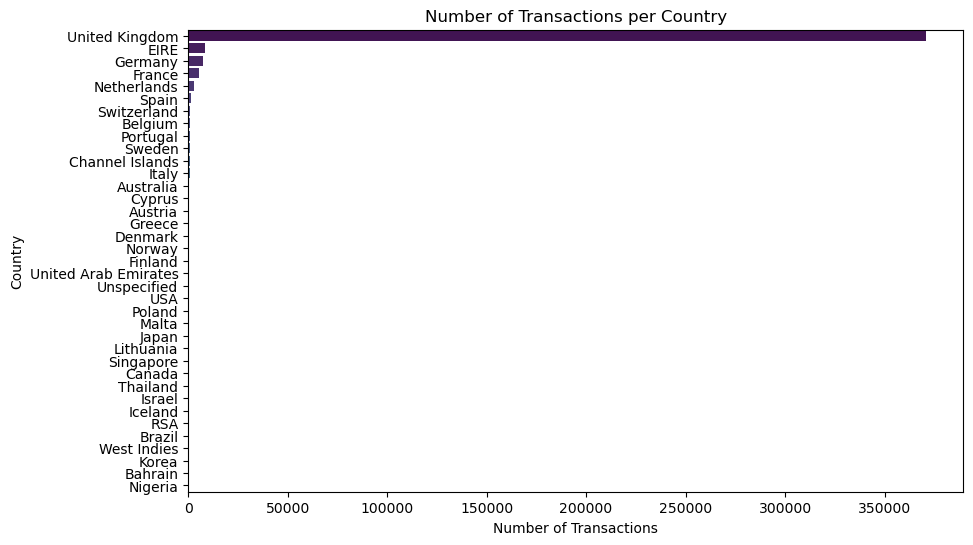

In [59]:
# Group by country and count the number of transactions
country_counts = data_copy['Country'].value_counts()

# Plot the number of transactions per country
plt.figure(figsize=(10, 6))
sns.barplot(y=country_counts.index, x=country_counts.values, palette='viridis')
plt.title('Number of Transactions per Country')
plt.xlabel('Number of Transactions')
plt.ylabel('Country')
plt.show()

del country_counts

## View monthly sales trends to see months of most revenue

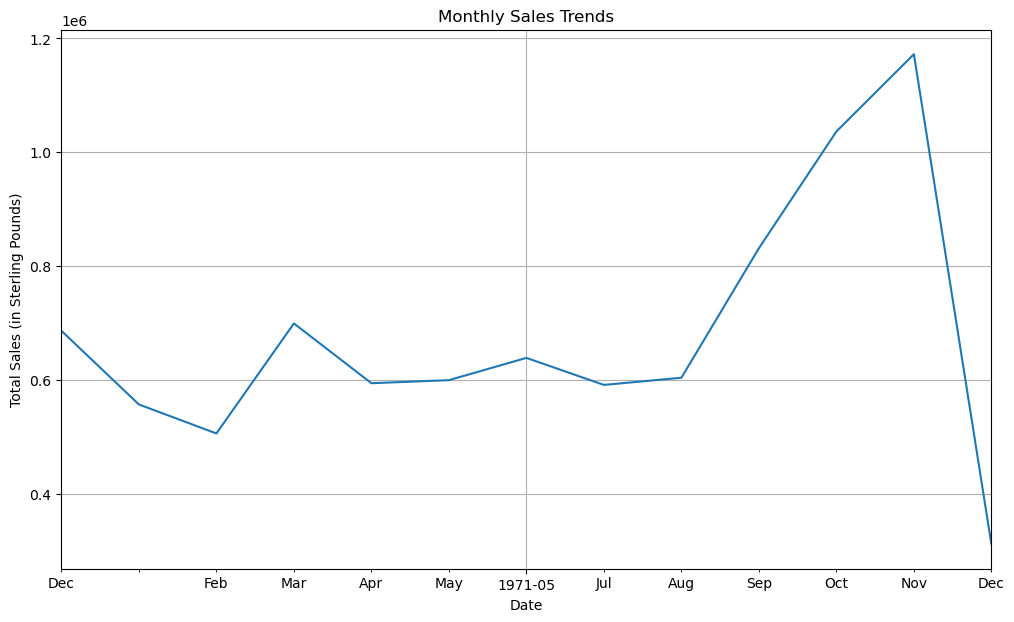

In [60]:
# Set the InvoiceDate as the index of the DataFrame
data_copy.set_index('InvoiceDate', inplace=True)

# Resample the data to monthly frequency and calculate the total sales for each month
monthly_sales = data_copy['TotalPrice'].resample('ME').sum()

# Plot the sales trends over time
plt.figure(figsize=(12, 7))
monthly_sales.plot()
plt.title('Monthly Sales Trends')
plt.xlabel('Date')
plt.ylabel('Total Sales (in Sterling Pounds)')
plt.grid(True)

# Customize the date format on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.show()

# Reset the index to avoid issues with subsequent operations
data_copy.reset_index(inplace=True)

del monthly_sales

## Items that generate the most revenue and total revenue

In [61]:
# Group by item description and sum the total price for each item
item_revenue = data_copy.groupby('Description')['TotalPrice'].sum()

# Sort the items by revenue in descending order
top_items = item_revenue.sort_values(ascending=False)
# Calculate the percentage of total revenue for each item
total_revenue = top_items.sum()
top_items_percentage = (top_items / total_revenue) * 100

print("Total revenue: (sterling pounds) £", total_revenue, '\n')

# Combine the revenue and percentage into a single DataFrame
top_items_df = pd.DataFrame({'Revenue': top_items, 'Percentage': top_items_percentage})

print("Top 10 items generating the most revenue (in £):\n", top_items_df.head(10))

del item_revenue, top_items, top_items_percentage, top_items_df

Total revenue: (sterling pounds) £ 8832003.274 

Top 10 items generating the most revenue (in £):
                                        Revenue  Percentage
Description                                               
WHITE HANGING HEART T-LIGHT HOLDER   151624.31    1.716760
REGENCY CAKESTAND 3 TIER             143893.35    1.629227
Manual                                98560.64    1.115949
ASSORTED COLOUR BIRD ORNAMENT         70493.83    0.798164
JUMBO BAG RED RETROSPOT               51759.30    0.586043
POSTAGE                               48741.08    0.551869
ROTATING SILVER ANGELS T-LIGHT HLDR   40186.65    0.455012
PAPER CHAIN KIT 50'S CHRISTMAS        36933.50    0.418178
PARTY BUNTING                         35035.90    0.396693
EDWARDIAN PARASOL NATURAL             34044.75    0.385470


## Identifying which time of the day accounts for the most revenue generated

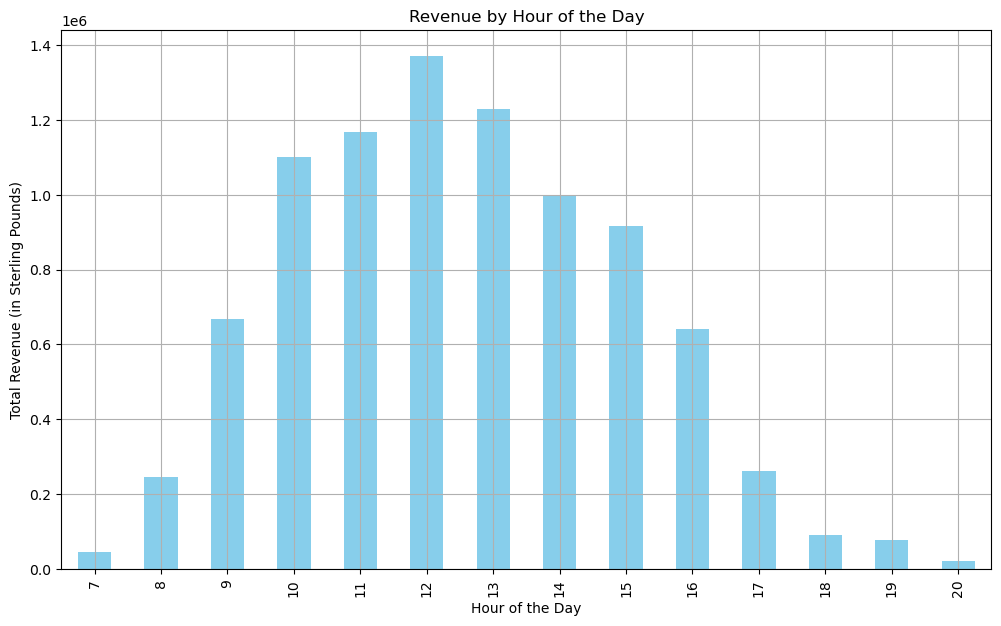

In [62]:
# Extract the hour from the InvoiceDate column and add it to data_copy
data_copy['Hour'] = data_copy['InvoiceDate'].dt.hour

# Extract the hour from the InvoiceDate column and group by the hour to sum the TotalPrice for each hour
hourly_revenue = data_copy.groupby(data_copy['InvoiceDate'].dt.hour)['TotalPrice'].sum()

# Plot the hourly revenue
plt.figure(figsize=(12, 7))
hourly_revenue.plot(kind='bar', color='skyblue')
plt.title('Revenue by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Revenue (in Sterling Pounds)')
plt.grid(True)
plt.show()

del hourly_revenue

## Identifying which day of the week accounts for the most revenue generated

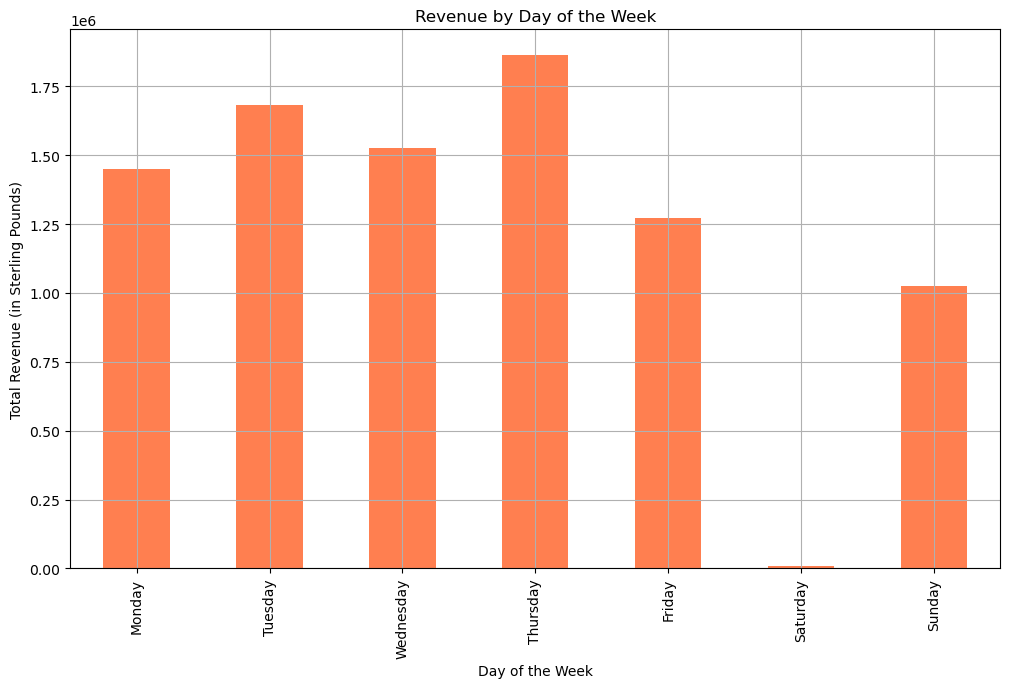

In [63]:
# Extract the day of the week from the InvoiceDate column and add it to data_copy
data_copy['DayOfWeek'] = data_copy['InvoiceDate'].dt.day_name()

day_of_week_revenue = data_copy.copy()
day_of_week_revenue['DayOfWeek'] = day_of_week_revenue['InvoiceDate'].dt.day_name()

# Group by the day of the week and sum the TotalPrice for each day
day_of_week_revenue = day_of_week_revenue.groupby('DayOfWeek')['TotalPrice'].sum()

# Sort the days of the week in the correct order
day_of_week_revenue = day_of_week_revenue.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot the revenue by day of the week
plt.figure(figsize=(12, 7))
day_of_week_revenue.plot(kind='bar', color='coral')
plt.title('Revenue by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Revenue (in Sterling Pounds)')
plt.grid(True)
plt.show()

del day_of_week_revenue

## Find how many customers are repeat customers

Number of repeat customers: 2893
Number of non-repeat customers: 1419


C:\Users\harry\AppData\Local\Temp\ipykernel_17628\1216517499.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Repeat Customers', 'Non-Repeat Customers'], y=[repeat_customers, non_repeat_customers], palette='pastel')


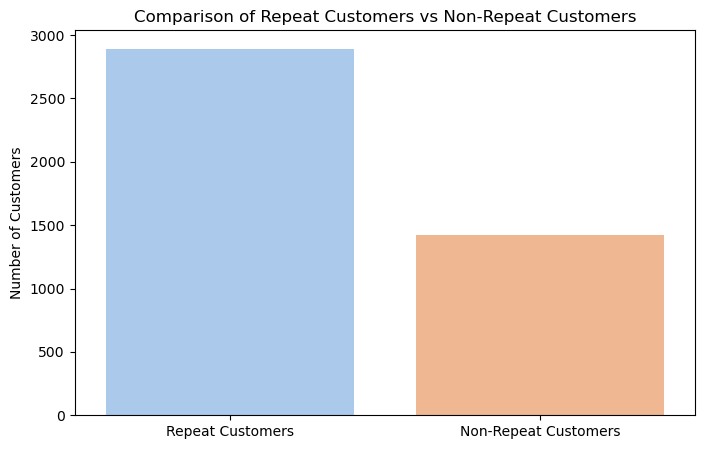

In [64]:
# Group by CustomerID and count the number of unique InvoiceNo for each customer
customer_invoices = data_copy.groupby('CustomerID')['InvoiceNo'].nunique()

# Classify customers as repeat or non-repeat
repeat_customers = customer_invoices[customer_invoices > 1].count()
non_repeat_customers = customer_invoices[customer_invoices == 1].count()

# Print the results
print(f"Number of repeat customers: {repeat_customers}")
print(f"Number of non-repeat customers: {non_repeat_customers}")

# Plot the comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=['Repeat Customers', 'Non-Repeat Customers'], y=[repeat_customers, non_repeat_customers], palette='pastel')
plt.title('Comparison of Repeat Customers vs Non-Repeat Customers')
plt.ylabel('Number of Customers')
plt.show()

del repeat_customers, non_repeat_customers

## Identify top customers, amount of revenue they bring in, and whether or not they are repeat customers

In [65]:
# Group by CustomerID and sum the TotalPrice for each customer
customer_revenue = data_copy.groupby('CustomerID')['TotalPrice'].sum()

# Sort the customers by revenue in descending order
top_customers = customer_revenue.sort_values(ascending=False)

# Determine the top 10 customers by revenue
top_10_customers = top_customers.head(10)

# Check if the top customers are repeat customers
top_10_customers_repeat_status = customer_invoices[top_10_customers.index].apply(lambda x: 'Repeat' if x > 1 else 'Non-Repeat')

# Calculate the percentage of total revenue for each top customer
top_10_customers_percentage = (top_10_customers / total_revenue) * 100

# Combine the revenue, percentage, and repeat status into a single DataFrame
top_10_customers_df = pd.DataFrame({
    'Revenue': top_10_customers,
    'Percentage of Total Revenue': top_10_customers_percentage,
    'Repeat Status': top_10_customers_repeat_status
})

print("Top 10 customers by revenue, their repeat status, and percentage of total revenue:\n")
top_10_customers_df

del top_10_customers, top_10_customers_repeat_status, top_10_customers_percentage, top_customers, top_10_customers_df

Top 10 customers by revenue, their repeat status, and percentage of total revenue:



# 2. Customer Segmentation (Clustering)
## Recency, Frequency, and Monetary (RFM) clustering analysis using k-means

Cluster
0    2930
1    1030
4     334
2      14
3       4
Name: count, dtype: int64


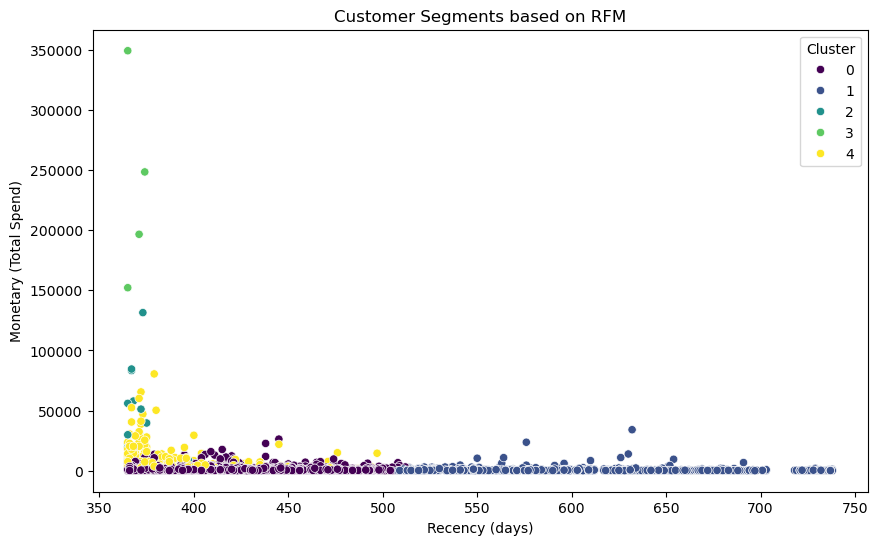

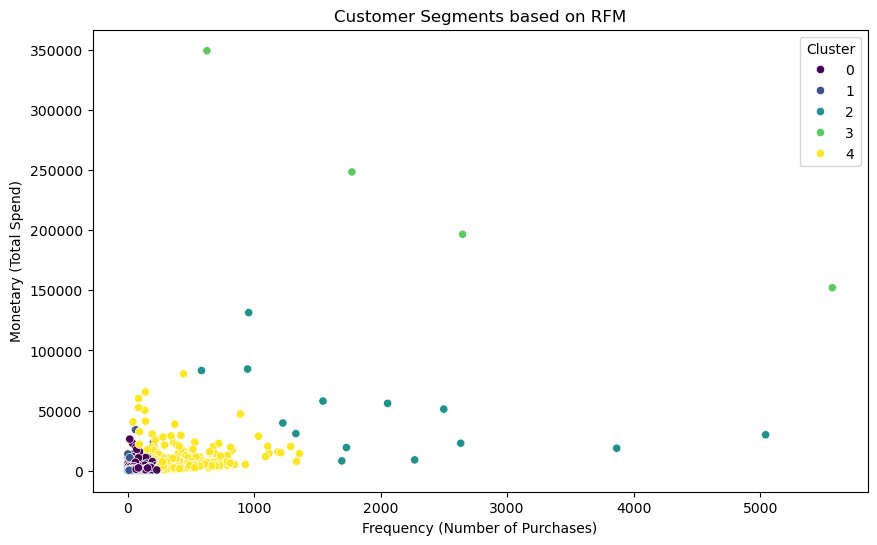

In [95]:
# Calculate Recency, Frequency, and Monetary (RFM) metrics

# Assuming data_copy is your cleaned DataFrame
current_date = dt.datetime(2011, 12, 10)  # Set to the last date in your dataset

rfm = data_copy.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Standardize the RFM metrics
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Analyze the clusters
print(rfm['Cluster'].value_counts())

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm, palette='viridis')
plt.title('Customer Segments based on RFM')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary (Total Spend)')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=rfm, palette='viridis')
plt.title('Customer Segments based on RFM')
plt.xlabel('Frequency (Number of Purchases)')
plt.ylabel('Monetary (Total Spend)')
plt.legend(title='Cluster')
plt.show()

del rfm, rfm_scaled, scaler, kmeans, current_date

The RFM clustering shows that recency does seem to play a role in the total spend of a customer, with a higher spend closer with a lower reeceny and some small jumps in monetary spend at certain intervals being 440 days and in between 570-630 days.

### See if there are any potential patterns based on time of purchase of customers

C:\Users\harry\AppData\Local\Temp\ipykernel_17628\891616921.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_features['DayOfWeek'] = time_features['DayOfWeek'].map({


Cluster counts based on DayOfWeek:
 Cluster_DayOfWeek
0    2171
4    1443
1     677
2      18
3       3
Name: count, dtype: int64
Cluster counts based on Month:
 Cluster_Month
1    2175
2    1079
0    1038
4      17
3       3
Name: count, dtype: int64
Cluster counts based on Hour:
 Cluster_Hour
0    2199
2    1735
1     358
4      17
3       3
Name: count, dtype: int64


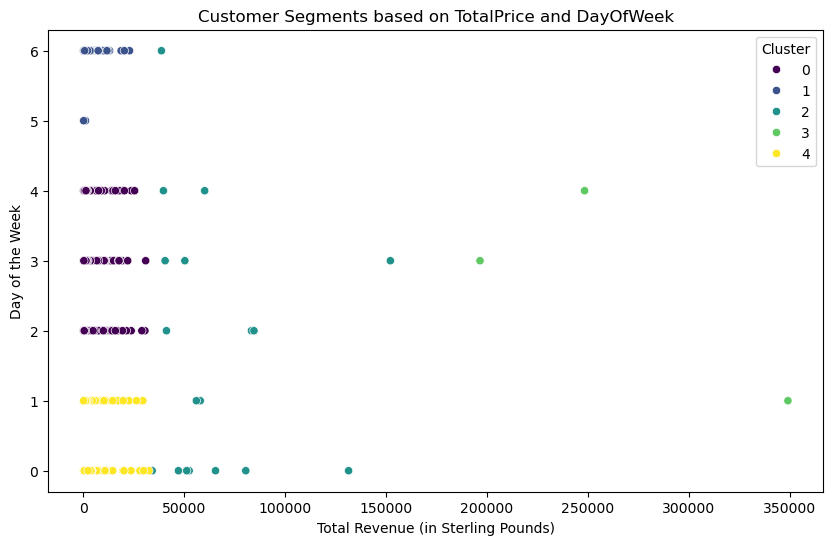

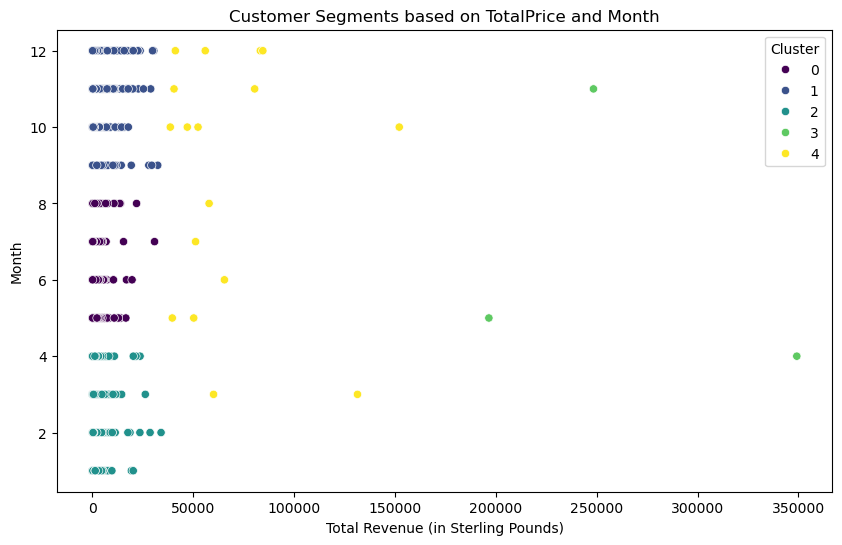

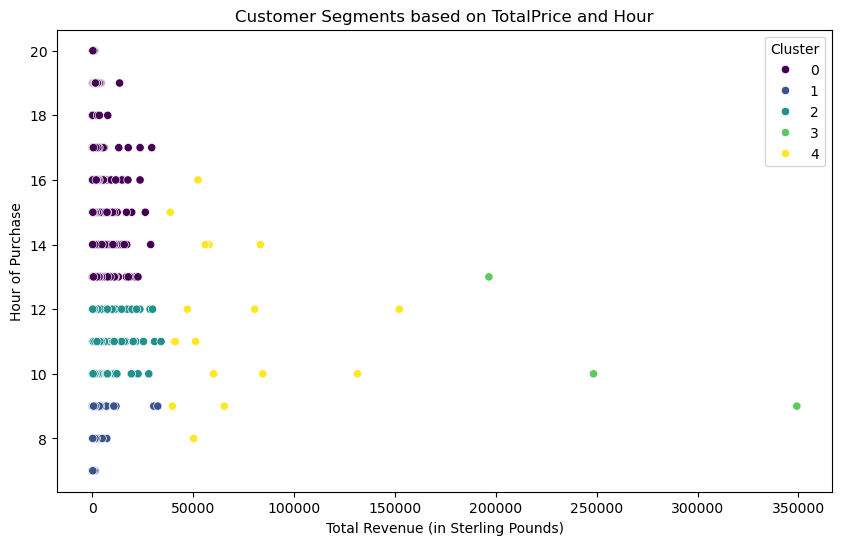

In [91]:
# Extract relevant features for clustering
time_features = data_copy[['CustomerID', 'TotalPrice', 'DayOfWeek', 'Month', 'Hour']]

# Convert categorical 'DayOfWeek' to numerical values
time_features['DayOfWeek'] = time_features['DayOfWeek'].map({
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
})

# Group by CustomerID and aggregate the features
time_features_agg = time_features.groupby('CustomerID').agg({
    'TotalPrice': 'sum',
    'DayOfWeek': lambda x: x.mode()[0],  # Most common day of the week
    'Month': lambda x: x.mode()[0],      # Most common month
    'Hour': lambda x: x.mode()[0]        # Most common hour
}).reset_index()

# Standardize the features
scaler = StandardScaler()

# Clustering based on TotalPrice and DayOfWeek
features_dayofweek = time_features_agg[['TotalPrice', 'DayOfWeek']]
features_dayofweek_scaled = scaler.fit_transform(features_dayofweek)
kmeans_dayofweek = KMeans(n_clusters=5, random_state=42)
time_features_agg['Cluster_DayOfWeek'] = kmeans_dayofweek.fit_predict(features_dayofweek_scaled)

# Clustering based on TotalPrice and Month
features_month = time_features_agg[['TotalPrice', 'Month']]
features_month_scaled = scaler.fit_transform(features_month)
kmeans_month = KMeans(n_clusters=5, random_state=42)
time_features_agg['Cluster_Month'] = kmeans_month.fit_predict(features_month_scaled)

# Clustering based on TotalPrice and Hour
features_hour = time_features_agg[['TotalPrice', 'Hour']]
features_hour_scaled = scaler.fit_transform(features_hour)
kmeans_hour = KMeans(n_clusters=5, random_state=42)
time_features_agg['Cluster_Hour'] = kmeans_hour.fit_predict(features_hour_scaled)

# Analyze the clusters
print("Cluster counts based on DayOfWeek:\n", time_features_agg['Cluster_DayOfWeek'].value_counts())
print("Cluster counts based on Month:\n", time_features_agg['Cluster_Month'].value_counts())
print("Cluster counts based on Hour:\n", time_features_agg['Cluster_Hour'].value_counts())

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalPrice', y='DayOfWeek', hue='Cluster_DayOfWeek', data=time_features_agg, palette='viridis')
plt.title('Customer Segments based on TotalPrice and DayOfWeek')
plt.xlabel('Total Revenue (in Sterling Pounds)')
plt.ylabel('Day of the Week')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalPrice', y='Month', hue='Cluster_Month', data=time_features_agg, palette='viridis')
plt.title('Customer Segments based on TotalPrice and Month')
plt.xlabel('Total Revenue (in Sterling Pounds)')
plt.ylabel('Month')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalPrice', y='Hour', hue='Cluster_Hour', data=time_features_agg, palette='viridis')
plt.title('Customer Segments based on TotalPrice and Hour')
plt.xlabel('Total Revenue (in Sterling Pounds)')
plt.ylabel('Hour of Purchase')
plt.legend(title='Cluster')
plt.show()

del time_features, time_features_agg, features_dayofweek, features_dayofweek_scaled, kmeans_dayofweek
del features_month, features_month_scaled, kmeans_month
del features_hour, features_hour_scaled, kmeans_hour

The lack of clearly-defined clusters based on k-means using customer metrics of when they purchased compared to their total revenue implies that individual customers collectively are not prone to buying more based on time of purchase.

# 3. Customer Purchase Prediction
#### IMORTANT: This is the part of the project description that is most affected by the misinterpretation of the data. Since all customers in the transaction data made a purchase, there is no need to analyze where certain habits will lead to a purchase
#### ADAPTION: Instead of whether or not they will purchase, if they purchase over a certain amount

In [120]:
# Calculate the mean purchasing amount each customer brings to the business
mean_purchase_amount = customer_revenue.mean()

print(f"The mean purchasing amount each customer brings to the business is and will be the monetary threshold: £{mean_purchase_amount:.2f}")

del mean_purchase_amount

The mean purchasing amount each customer brings to the business is and will be the monetary threshold: £2048.24


In [121]:
# Define the threshold
threshold = customer_revenue.mean()

# Display the columns of customer_features
print("Columns in customer_features:\n", customer_features.columns, '\n\n')

# Create a new column 'AboveThreshold' in customer_features
customer_features['AboveThreshold'] = (customer_features['TotalRevenue'] > threshold).astype(int)

# Define features and target
X = customer_features.drop(columns=['TotalRevenue', 'AboveThreshold'])
y = customer_features['AboveThreshold']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

del threshold

Columns in customer_features:
 Index(['InvoiceCount', 'TotalRevenue', 'CommonPurchaseMonth',
       'CommonPurchaseHour', 'Cluster', 'AboveThreshold'],
      dtype='object') 


Confusion Matrix:
 [[637  42]
 [ 60 124]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.93       679
           1       0.75      0.67      0.71       184

    accuracy                           0.88       863
   macro avg       0.83      0.81      0.82       863
weighted avg       0.88      0.88      0.88       863



This data shows the results from runnning a random forest classification model to determine whether or not a customer will spend over a threshold amount, in this case above 2048 sterling pounds. Different customer features were displayed followed by the results including a confusion matrix and classification report showing accuracy. The matrix indicates a high percentage of true positives and true negatives and an overall high accuracy around 83 percent. So, high revenue generating customers can be targeted to induce higher transaction amounts through incentives.

# 4. Sales Forecasting (Regression)

Mean Squared Error: 22767488.14096724
R-squared: 0.18306094283771956


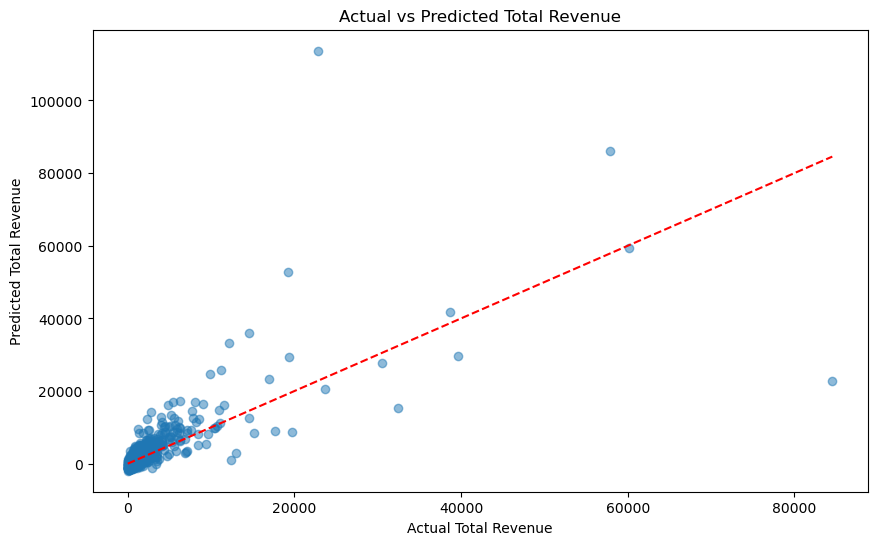

In [ ]:
# Define features and target for regression
X_reg = customer_features.drop(columns=['TotalRevenue', 'AboveThreshold'])
y_reg = customer_features['TotalRevenue']

# Split the data into training and testing sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Initialize the LinearRegression model
reg = LinearRegression()

# Train the model
reg.fit(X_train_reg, y_train_reg)

# Make predictions
y_pred_reg = reg.predict(X_test_reg)

# Evaluate the model
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.xlabel('Actual Total Revenue')
plt.ylabel('Predicted Total Revenue')
plt.title('Actual vs Predicted Total Revenue')
plt.show()

del X_reg, y_reg, X_train_reg, X_test_reg, y_train_reg, y_test_reg, reg, y_pred_reg, mse, r2

# 5. Product Bundling

In [ ]:
#